In [1]:
import re
import json
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns

# NLTK Stop words
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

# spacy for lemmatization
import spacy

#remove urls, mentions, emojis 
import preprocessor as p

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt

In [2]:
filepath = '/Users/lavine/Desktop/Terriers!/misinformation project/data/data.txt'

### Create a dataframe by every columns

In [3]:
#load all the JSON objects in one list as dictionaries
data = []
with open(filepath,'r') as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
data[9]['text']

'\'We are in a climate emergency\'December wildfires ravage Colorado https://t.co/sWDkZM4Rvn Sen. Manchin, your Exxon highway bill isn\'t going 2save our homes or our lives," "Your greed &amp; corruption is not only torching our future It\'s burning our communities and destroying lives!'

In [5]:
data[4]['referenced_tweets'][0]['text']

'@ScottGrimnes @MaMan564 @SoFarFletched ‘We’ started calling it ‘climate change’ when Exxon Mobile did a very successful PR campaign in the 90’s. Apparently ‘global warming’ is too specific and scary. But It’s global warming. https://t.co/WPetiWDQG3'

 #### Put the text data in one list

In [6]:
#retrive text and avoid truncated text when retweet without quoting
lst_text = []
for i in data:    
    if 'referenced_tweets' in i:
        if i['referenced_tweets'][0]['type'] == 'retweeted':
            lst_text.append(i['referenced_tweets'][0]['text'])
        else:
            lst_text.append(i['text'])
    else:
        lst_text.append(i['text'])

In [7]:
lst_text[:2]

['@tjbabel @Catherine_LCP @SamBoik @Cernovich https://t.co/a5p9XOE7b9',
 '@tjbabel @Catherine_LCP @SamBoik @Cernovich https://t.co/BRBvadbSVr']

 #### Put the author info in list

In [8]:
data[0].keys()

dict_keys(['lang', 'id', 'possibly_sensitive', 'author_id', 'text', 'referenced_tweets', 'created_at', 'source', 'entities', 'in_reply_to_user_id', 'reply_settings', 'conversation_id', 'public_metrics', 'author', 'in_reply_to_user', '__twarc'])

 ##### 'id', 'author_id', 'conversation_id', 'author'

In [9]:
#create lists for id, author id and conversation
lst_id = []
lst_lang = []
lst_author_id = []
lst_conversation_id = []
for i in data:
    lst_id.append(i['id'])
    lst_lang.append(i['lang'])
    lst_author_id.append(i['author_id'])
    lst_conversation_id.append(i['conversation_id'])

There are too much info in author dictionary

In [10]:
data[0]

{'lang': 'und',
 'id': '1477065589361315842',
 'possibly_sensitive': False,
 'author_id': '1460383957262880776',
 'text': '@tjbabel @Catherine_LCP @SamBoik @Cernovich https://t.co/a5p9XOE7b9',
 'referenced_tweets': [{'type': 'replied_to',
   'id': '1477064685639782404',
   'lang': 'en',
   'possibly_sensitive': False,
   'author_id': '1733391854',
   'text': '@owen_lavine @Catherine_LCP @SamBoik @Cernovich Ever heard of the carbon cycle? Google it.',
   'entities': {'annotations': [{'start': 80,
      'end': 85,
      'probability': 0.4095,
      'type': 'Organization',
      'normalized_text': 'Google'}],
    'mentions': [{'start': 0,
      'end': 12,
      'username': 'owen_lavine',
      'id': '1460383957262880776',
      'verified': False,
      'created_at': '2021-11-15T23:07:29.000Z',
      'public_metrics': {'followers_count': 12,
       'following_count': 245,
       'tweet_count': 963,
       'listed_count': 0},
      'name': 'Owen Lavine',
      'description': 'Journalist - C

In [11]:
#lst verified or not, author name and author username
lst_author_verified = []
lst_author_name = []
lst_author_username = []
for i in data:
    lst_author_verified.append(i['author']['verified'])
    lst_author_name.append(i['author']['name'])
    lst_author_username.append(i['author']['username'])

 ##### Make creation time

In [12]:
#list creation time
lst_twt_creation_time = []
for i in data:
    lst_twt_creation_time.append(i['created_at'])

##### Put what we have in one dataframe

lst_text,lst_id, lst_author_id,lst_conversation_id,lst_author_verified, lst_author_name, lst_author_username,lst_twt_creation_time

In [13]:
tweets = pd.DataFrame({'text': lst_text,
                  'language': lst_lang,
                  'id': lst_id,
                  'author_id': lst_author_id,
                  'conversation_id': lst_conversation_id,
                  'author_verified': lst_author_verified,
                  'author_name': lst_author_name,
                  'author_username': lst_author_username,
                  'twt_creation_time': lst_twt_creation_time
                  })

In [14]:
pd.set_option("display.max_colwidth", 10000)

In [15]:
tweets.drop(tweets[tweets['language'] != 'en'].index, inplace = True)

In [16]:
tweets.head()

,text,language,id,author_id,conversation_id,author_verified,author_name,author_username,twt_creation_time
2,"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose. 😔",en,1477059914015125507,2732778706,1477059914015125507,False,Tai Chi,TaiWendysb,2021-12-31T23:31:40.000Z
3,"@Mum2Mrs @oshima9 no, capitalists are the cause.\nhttps://t.co/VyFfKhY2Yp",en,1477056800889323523,414239235,1477056800889323523,False,Richard Estes,oshima9,2021-12-31T23:19:18.000Z
4,@ScottGrimnes @MaMan564 @SoFarFletched ‘We’ started calling it ‘climate change’ when Exxon Mobile did a very successful PR campaign in the 90’s. Apparently ‘global warming’ is too specific and scary. But It’s global warming. https://t.co/WPetiWDQG3,en,1477046502400868359,824946672673361920,1477046502400868359,False,Kris,writing_callous,2021-12-31T22:38:23.000Z
5,"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose. 😔",en,1477040827503362057,2429328178,1477040827503362057,False,David💙l🇪🇺#FindMissyandBiscuit,David96212152,2021-12-31T22:15:50.000Z
6,"@Mum2Mrs @oshima9 no, capitalists are the cause.\nhttps://t.co/VyFfKhY2Yp",en,1477035647462363141,795750344970141701,1476641658636693513,False,☭🇵🇸🇾🇪🇸🇾,zia_kat,2021-12-31T21:55:15.000Z


### Data preprocessing

In [17]:
tweets['hashtag'] = tweets['text'].apply(lambda x: re.findall(r"#(\w+)", x))

In [18]:
#forming a separate feature for cleaned tweets
tweets['ctext'] = tweets['text'].apply(lambda x: p.clean(x))

In [19]:
tweets.head(3)

,text,language,id,author_id,conversation_id,author_verified,author_name,author_username,twt_creation_time,hashtag,ctext
2,"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose. 😔",en,1477059914015125507,2732778706,1477059914015125507,False,Tai Chi,TaiWendysb,2021-12-31T23:31:40.000Z,[],"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose."
3,"@Mum2Mrs @oshima9 no, capitalists are the cause.\nhttps://t.co/VyFfKhY2Yp",en,1477056800889323523,414239235,1477056800889323523,False,Richard Estes,oshima9,2021-12-31T23:19:18.000Z,[],"no, capitalists are the cause."
4,@ScottGrimnes @MaMan564 @SoFarFletched ‘We’ started calling it ‘climate change’ when Exxon Mobile did a very successful PR campaign in the 90’s. Apparently ‘global warming’ is too specific and scary. But It’s global warming. https://t.co/WPetiWDQG3,en,1477046502400868359,824946672673361920,1477046502400868359,False,Kris,writing_callous,2021-12-31T22:38:23.000Z,[],We started calling it climate change when Exxon Mobile did a very successful PR campaign in the s. Apparently global warming is too specific and scary. But Its global warming.


In [20]:
#convert to list
ctext = tweets['ctext'].tolist()

In [21]:
# Remove new line characters
ctext = [re.sub('\s+', ' ', sent) for sent in ctext]

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
/var/folders/kg/0ndh6pln2x7b6rpm16twhvpc0000gn/T/ipykernel_6968/1351202947.py:2: DeprecationWarning: invalid escape sequence \s
  ctext = [re.sub('\s+', ' ', sent) for sent in ctext]


In [22]:
# Remove distracting single quotes
ctext = [re.sub("\'", "", sent) for sent in ctext]

In [23]:
# remove punctuations
ctext = [re.sub(r'[^\w\s]', '', sent) for sent in ctext]

In [24]:
ctext[1:5]

['no capitalists are the cause',
 'We started calling it climate change when Exxon Mobile did a very successful PR campaign in the s Apparently global warming is too specific and scary But Its global warming',
 'Im thinking about writing a satire where the US Congress is blocked from taking action on the climate by a Senator who owns a coal company lives on a yacht and speaks daily with Exxon lobbyists  but Im worried people will think its too on the nose',
 'no capitalists are the cause']

### Tokenize words and further clean up text

In [25]:
#tokenize each sentence into a list of words, removing punctuations and unnecessary characters altoghter

In [26]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

tweet_words = list(sent_to_words(ctext))

print(tweet_words[:1])

[['im', 'thinking', 'about', 'writing', 'satire', 'where', 'the', 'us', 'congress', 'is', 'blocked', 'from', 'taking', 'action', 'on', 'the', 'climate', 'by', 'senator', 'who', 'owns', 'coal', 'company', 'lives', 'on', 'yacht', 'and', 'speaks', 'daily', 'with', 'exxon', 'lobbyists', 'but', 'im', 'worried', 'people', 'will', 'think', 'its', 'too', 'on', 'the', 'nose']]


In [27]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tweet_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tweet_words[0]]])

['im', 'thinking', 'about_writing_satire', 'where', 'the', 'us', 'congress', 'is', 'blocked', 'from', 'taking', 'action', 'on', 'the', 'climate', 'by', 'senator', 'who', 'owns', 'coal', 'company', 'lives', 'on', 'yacht', 'and', 'speaks', 'daily', 'with', 'exxon', 'lobbyists', 'but', 'im', 'worried', 'people', 'will', 'think', 'its', 'too', 'on', 'the', 'nose']


### Remove Stopwords, Make Bigrams and Lemmatize

In [43]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'm'])

In [44]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [45]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [46]:
# Remove Stop Words
tweet_words_nostops = remove_stopwords(tweet_words)

In [47]:
# Form Bigrams
tweet_words_bigrams = make_bigrams(tweet_words_nostops)

In [48]:
# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])# not "en" any more

# Do lemmatization keeping only noun, adj, vb, adv
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(tweet_lemmatized[:1])

[['m', 'think', 'block', 'take', 'action', 'climate', 'senator', 'own', 'coal', 'company', 'live', 'yacht', 'speak', 'daily', 'lobbyist', 'm', 'worried', 'people', 'think', 'nose']]


### Creat the dictionary and the corpus

In [49]:
# Create Dictionary
id2word = corpora.Dictionary(tweet_lemmatized)

# Create Corpus
texts = tweet_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts] 

#Gensim creates a unique id for each word in the document. 
#The produced corpus shown below is a mapping of (word_id, word_frequency(times of occurance)).

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1)]]


In [50]:
id2word[40]

'environment'

In [51]:
#If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.
id2word[4]

#in put of LDA

'company'

In [52]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('action', 1),
  ('block', 1),
  ('climate', 1),
  ('coal', 1),
  ('company', 1),
  ('daily', 1),
  ('live', 1),
  ('lobbyist', 1),
  ('m', 2),
  ('nose', 1),
  ('own', 1),
  ('people', 1),
  ('senator', 1),
  ('speak', 1),
  ('take', 1),
  ('think', 2),
  ('worried', 1),
  ('yacht', 1)]]

### Building the Topic Model

In [65]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [66]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.117*"involve" + 0.071*"company" + 0.063*"see" + 0.057*"ad" + '
  '0.055*"director" + 0.055*"recuse" + 0.055*"amy_coney" + '
  '0.055*"stricter_ethic" + 0.049*"order" + 0.028*"liberal"'),
 (1,
  '0.103*"climate" + 0.049*"change" + 0.026*"case" + 0.021*"shell" + '
  '0.019*"court" + 0.018*"major" + 0.015*"fund" + 0.014*"industry" + '
  '0.014*"amp" + 0.014*"law"'),
 (2,
  '0.097*"use" + 0.075*"world" + 0.064*"work" + 0.059*"business" + '
  '0.041*"member" + 0.034*"former" + 0.030*"lee_raymond" + 0.029*"quit" + '
  '0.028*"twoand" + 0.026*"role"'),
 (3,
  '0.119*"job" + 0.096*"today" + 0.066*"decade" + 0.053*"action" + '
  '0.052*"exxon" + 0.050*"climate" + 0.034*"report" + 0.031*"hold" + '
  '0.029*"re" + 0.025*"dark"'),
 (4,
  '0.058*"oil" + 0.055*"emission" + 0.052*"company" + 0.046*"know" + '
  '0.042*"big" + 0.028*"shareholder" + 0.022*"investor" + 0.021*"new" + '
  '0.021*"climate" + 0.020*"cut"'),
 (5,
  '0.050*"fuel" + 0.038*"fossil" + 0.030*"energy" + 0.028*"need" + 0.0

### Compute model perplexity and coherence score

In [67]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tweet_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.289467044863519

Coherence Score:  0.34398067146741557


In [69]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.144736 -0.061881       1        1  30.778806
4      0.177529 -0.135716       2        1  21.651686
5     -0.158239 -0.233604       3        1  17.856816
3     -0.081349 -0.032717       4        1  15.572393
0      0.367867  0.094972       5        1   7.913725
2     -0.161072  0.368946       6        1   6.226574, topic_info=                     Term          Freq          Total Category  logprob  \
125                   job  74592.000000   74592.000000  Default  30.0000   
250                 today  60222.000000   60222.000000  Default  29.0000   
4                 company  67772.000000   67772.000000  Default  28.0000   
1788              involve  37066.000000   37066.000000  Default  27.0000   
38                    oil  50433.000000   50433.000000  Default  26.0000   
...                   ...           ...            ...      ...      ...   
18150        holding_bank   5464.168824    6144.284756   Topic6  -3.8241   
18124  lobby_organization   3225.537941    3615.264709   Topic6  -4.3512   
17283            stepping   3776.931811    5452.217123   Topic6  -4.1934   
9105             valuable   2454.898813    5529.118716   Topic6  -4.6242   
2                 climate   3986.963361  196448.547660   Topic6  -4.1393   

       loglift  
125    30.0000  
250    29.0000  
4      28.0000  
1788   27.0000  
38     26.0000  
...        ...  
18150   2.6590  
18124   2.6623  
17283   2.4092  
9105    1.9644  
2      -1.1210  

[259 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
3105       1  0.000349         ability
3105       2  0.000698         ability
3105       4  0.000349         ability
3105       6  0.998827         ability
0          4  0.999803          action
...      ...       ...             ...
483        4  0.000085          yearly
17733      1  0.109048  young_engineer
17733      2  0.001018  young_engineer
17733      3  0.001696  young_engineer
17733      4  0.887988  young_engineer

[522 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 6, 4, 1, 3])

# The Following code are still being working on

### Find the optimal number of topics

In [57]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [58]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tweet_lemmatized, start=2, limit=10, step=2)

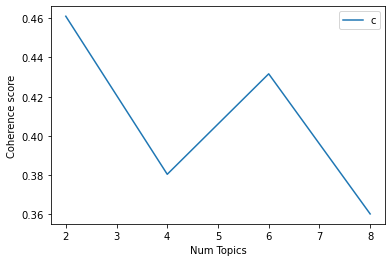

In [59]:
# Show graph
limit=10; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [60]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.461
Num Topics = 4  has Coherence Value of 0.3805
Num Topics = 6  has Coherence Value of 0.4317
Num Topics = 8  has Coherence Value of 0.3603


In [61]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.076*"climate" + 0.030*"company" + 0.026*"shareholder" + 0.024*"go" + '
  '0.022*"today" + 0.019*"break" + 0.017*"case" + 0.014*"change" + '
  '0.014*"involve" + 0.014*"know"'),
 (1,
  '0.075*"change" + 0.073*"activist" + 0.044*"law" + 0.038*"good" + '
  '0.038*"board" + 0.033*"work" + 0.022*"business" + 0.022*"stand" + '
  '0.021*"put" + 0.021*"exxon"'),
 (2,
  '0.119*"point" + 0.043*"problem" + 0.041*"try" + 0.041*"capture" + '
  '0.035*"week" + 0.034*"say" + 0.029*"blame" + 0.026*"mean" + 0.026*"report" '
  '+ 0.024*"re"'),
 (3,
  '0.070*"emission" + 0.042*"know" + 0.040*"end" + 0.039*"era" + '
  '0.038*"turning" + 0.038*"halve" + 0.038*"ecuador" + 0.038*"slam" + '
  '0.038*"planetdutch" + 0.038*"likely"'),
 (4,
  '0.061*"climate" + 0.053*"emission" + 0.051*"oil" + 0.047*"cut" + '
  '0.039*"shell" + 0.038*"chevron" + 0.032*"day" + 0.025*"director" + '
  '0.025*"major" + 0.024*"elect"'),
 (5,
  '0.078*"court" + 0.066*"fuel" + 0.059*"big" + 0.052*"fossil" + '
  '0.052*"invest

### Finding the dominant topic in each sentence

In [62]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.8979   
1            1             0.0              0.7191   
2            2             0.0              0.8466   
3            3             0.0              0.8979   
4            4             0.0              0.7191   

                                                                       Keywords  \
0  climate, company, shareholder, go, today, break, case, change, involve, know   
1  climate, company, shareholder, go, today, break, case, change, involve, know   
2  climate, company, shareholder, go, today, break, case, change, involve, know   
3  climate, company, shareholder, go, today, break, case, change, involve, know   
4  climate, company, shareholder, go, today, break, case, change, involve, know   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

### Find the most representative document for each topic

In [63]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9618   
1        1.0              0.9477   
2        2.0              0.8910   
3        3.0              0.9404   
4        4.0              0.9411   

                                                                       Keywords  \
0  climate, company, shareholder, go, today, break, case, change, involve, know   
1         change, activist, law, good, board, work, business, stand, put, exxon   
2              point, problem, try, capture, week, say, blame, mean, report, re   
3  emission, know, end, era, turning, halve, ecuador, slam, planetdutch, likely   
4      climate, emission, oil, cut, shell, chevron, day, director, major, elect   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### Topic distribution across documents

In [64]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"climate, company, shareholder, go, today, break, case, change, involve, know",136609.0,0.5638
1.0,0.0,"climate, company, shareholder, go, today, break, case, change, involve, know",12089.0,0.0499
2.0,0.0,"climate, company, shareholder, go, today, break, case, change, involve, know",29744.0,0.1228
3.0,0.0,"climate, company, shareholder, go, today, break, case, change, involve, know",17741.0,0.0732
4.0,0.0,"climate, company, shareholder, go, today, break, case, change, involve, know",33595.0,0.1387
5.0,0.0,"climate, company, shareholder, go, today, break, case, change, involve, know",12504.0,0.0516
6.0,0.0,"climate, company, shareholder, go, today, break, case, change, involve, know",NaN,NaN
7.0,0.0,"climate, company, shareholder, go, today, break, case, change, involve, know",NaN,NaN
8.0,0.0,"climate, company, shareholder, go, today, break, case, change, involve, know",NaN,NaN
9.0,0.0,"climate, company, shareholder, go, today, break, case, change, involve, know",NaN,NaN
